In [1]:
# import modules
import numpy as np
import pickle
import pandas as pd
from scipy.stats import norm

In [2]:
# initialisation (indexing for model retrieval)
num_reps = 100
config_ids = [36,37,38,39] # configuration ids of the optimal hyperparameter models
replication_ids = {}
failed_experiment_IDs = []

for index, config_id in enumerate(config_ids):
    experimentIDs = np.arange(index*num_reps+1,(index+1)*num_reps+1) # corresponding experiment IDs 
    # removing experiments that didn't run successfully
    experimentIDs = np.delete(experimentIDs,failed_experiment_IDs)
    replication_ids[config_id] = experimentIDs

In [3]:
# load appropriate data and obtain samples

# initialisation
date = '2025-02-04'
early_stopping = 100
root_dir = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\model_test_data"
root_dir_model = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\fit_models"
file_name_prefix = "long_experiment_"
file_name_suffix = f"_date_{date}_early_stopping_{early_stopping}"

In [4]:
return_variables = ['lon','lat','id','time','u','v','config_id','replication_id','mu_1','mu_2','sigma_11','sigma_22','sigma_12']
testing_data = pd.DataFrame(columns=return_variables)

In [5]:
for config_id in config_ids:
    for ii in range(num_reps):
        with open(fr'{root_dir}/{file_name_prefix}{replication_ids[config_id][ii]}{file_name_suffix}_test_data.p', 'rb') as pickle_file:
                    data = pickle.load(pickle_file)
                    data_df = data[0]
                    means = data[1][0]
                    covs = data[1][1]
                    # adding info
                    data_df['config_id'] = config_id
                    data_df['replication_id'] = ii
                    data_df['mu_1'], data_df['mu_2'] = means[:,0] , means[:,1] 
                    data_df['sigma_11'], data_df['sigma_22'], data_df['sigma_12'] = covs[:,0,0], covs[:,1,1], covs[:,0,1]
                    outvars = data_df[return_variables]
                    testing_data = pd.concat([testing_data,outvars],ignore_index=True)

C:\Users\vm2218\AppData\Local\Temp\ipykernel_3036\2865588473.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testing_data = pd.concat([testing_data,outvars],ignore_index=True)


In [6]:
# add residuals
testing_data['e_1'] = testing_data['u']-testing_data['mu_1']
testing_data['e_2'] = testing_data['v']-testing_data['mu_2']

In [7]:
# angle off-set
testing_data['angle_offset'] = np.einsum('ij,ij->i',testing_data[['u','v']].values,testing_data[['mu_1','mu_2']].values)
testing_data['angle_offset'] = np.divide(testing_data['angle_offset'], np.multiply(
    np.linalg.norm(testing_data[['u','v']].values,axis=1),np.linalg.norm(testing_data[['mu_1','mu_2']].values,axis=1)
    ))
testing_data['angle_offset'] = np.clip(testing_data['angle_offset'],-1,1)
testing_data['angle_offset'] = np.arccos(testing_data['angle_offset'])
testing_data['angle_offset']=np.rad2deg(testing_data['angle_offset'])

In [8]:
filehandler = open(f"analysis_data.p","wb")
pickle.dump(testing_data,filehandler,protocol=pickle.HIGHEST_PROTOCOL)

# Global Evaluation

## Point Metrics (Prediction Accuracy)

In [9]:
# group by configuration id
point_analysis_data = testing_data.groupby(['config_id','replication_id'])[['lat','lon','id','time','u','v','config_id','replication_id','mu_1','mu_2','sigma_11','sigma_22','sigma_12','e_1','e_2','angle_offset']]

### Metrics for each replication

In [10]:
global_point_metrics_by_replication = pd.DataFrame(columns=['RMSE','MdAPE','MAAO'])

In [11]:
# calculate rmse over all data points for each replication
rmse_per_config = point_analysis_data.apply(lambda g: 100*np.sqrt(np.mean(g["e_1"]**2 + g["e_2"]**2)/2))
global_point_metrics_by_replication['RMSE']=rmse_per_config

In [12]:
# calculate maao over all data points for each replication
maao_per_config = point_analysis_data.apply(lambda g: np.mean(g.loc[np.sqrt(g['mu_1']**2 + g['mu_2']**2) > 25/100, 'angle_offset']))
global_point_metrics_by_replication['MAAO']=maao_per_config

In [13]:
# calculate medAPE over all data points for each replication
mdAPE_per_config = point_analysis_data.apply(lambda g: np.median([100*np.abs(g["e_1"]/g["u"]), 100*np.abs(g["e_2"]/g["v"])]))
global_point_metrics_by_replication['MdAPE']=mdAPE_per_config

In [14]:
global_point_metrics_by_replication_data = global_point_metrics_by_replication.groupby('config_id')[['RMSE','MdAPE','MAAO']]

In [15]:
global_point_metrics_by_replication

RMSE      MdAPE       MAAO
config_id replication_id                                 
36        0               14.637541  66.080252  20.705480
          1               14.723423  65.559610  21.702928
          2               14.562164  65.194768  20.800226
          3               15.107037  66.898909  22.302671
          4               14.428255  67.619112  20.870114
...                             ...        ...        ...
39        95              14.152587  66.233602  21.407328
          96              14.518828  64.930363  20.884601
          97              14.789399  64.201933  20.901714
          98              15.329971  65.095423  21.653406
          99              14.396832  65.761084  20.644964

[400 rows x 3 columns]

### Summary of Point Metrics

In [16]:
global_point_metrics_summaries = pd.DataFrame(columns=['RMSE mean','RMSE std','MdAPE mean', 'MdAPE std','MAAO mean', 'MAAO std'])

In [17]:
import scipy.stats as stats

In [18]:
point_metric_names = ['RMSE','MdAPE','MAAO']


In [19]:
for name in point_metric_names:
    mean = global_point_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
    std = global_point_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
    ci = global_point_metrics_by_replication_data.apply(lambda g: stats.t.interval(confidence=0.95, df=g.size-1, 
              loc=np.mean(g[name]), 
              scale=np.std(g[name],ddof=1)))
    global_point_metrics_summaries[f'{name} mean']=mean
    global_point_metrics_summaries[f'{name} std']=std
    global_point_metrics_summaries[f'{name} ci']=ci

In [20]:
from hypothesis_test_functions import two_sample_one_sided_t_test

In [ ]:
X_1_name = '(SST-Enhanced) - (Baseline)'
X_2_name = 'Zero'

# (Baseline) - (SST-Enhanced) < zero is H0 and is what we want to reject

metric_name = 'RMSE'

X_1 = np.array(global_point_metrics_by_replication_data.get_group(36)[metric_name])
X_2 = np.array(global_point_metrics_by_replication_data.get_group(38)[metric_name])

diff = X_1-X_2


num_reps = 100
two_sample_one_sided_t_test(diff,np.zeros(len(diff)),num_reps,X_1_name,X_2_name,metric_name)


In [22]:
global_point_metrics_summaries

,RMSE mean,RMSE std,MdAPE mean,MdAPE std,MAAO mean,MAAO std,RMSE ci,MdAPE ci,MAAO ci
config_id,,,,,,,,,
36,14.783894,0.459634,66.159957,0.948322,21.651610,0.796068,"(13.879366794018896, 15.688421688992175)","(64.29372617131021, 68.02618705614633)","(20.085003565136738, 23.218216883867434)"
37,14.750128,0.460359,65.976940,0.941905,21.651381,0.787280,"(13.844173415992483, 15.65608224389014)","(64.12333796648197, 67.83054222585655)","(20.102068469780278, 23.200692912064632)"
38,14.542571,0.454691,65.546610,0.955865,20.860369,0.790967,"(13.647771336716257, 15.437369903270916)","(63.66553457412106, 67.42768622663688)","(19.30380262909002, 22.416935988068285)"
39,14.533736,0.456756,65.480731,0.920441,21.033217,0.771805,"(13.634873096186796, 15.43259880846013)","(63.669368568914436, 67.29209360296407)","(19.51436015683616, 22.55207432761265)"


In [23]:
# # Generate LaTeX tables
# non_polar_table = generate_latex_table(global_point_metrics_summaries.reset_index(), [36, 38], "tab:nonpolar_models", 
#                                        "Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", point_metric_names)
# polar_table = generate_latex_table(global_point_metrics_summaries.reset_index(), [37, 39], "tab:polar_models", 
#                                    "Performance metrics for polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", point_metric_names)

# # Print LaTeX tables
# print(non_polar_table)
# print(polar_table)

## Distribution Metrics (Prediction Accuracy)


### Metrics for Each Replication

In [24]:
def compute_nll(group):
    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    # Determinant of covariance matrix
    det_sigma = sigma_11 * sigma_22 - sigma_12 ** 2
    log_det_sigma = np.log(det_sigma)

    # Inverse of covariance matrix
    inv_sigma_11 = sigma_22 / det_sigma
    inv_sigma_22 = sigma_11 / det_sigma
    inv_sigma_12 = -sigma_12 / det_sigma

    # Compute quadratic term (Mahalanobis distance)
    e1, e2 = group["e_1"], group["e_2"]
    mahalanobis = (inv_sigma_11 * e1**2 + inv_sigma_22 * e2**2 + 2 * inv_sigma_12 * e1 * e2)

    # Compute NLL
    nll = 0.5 * (log_det_sigma + mahalanobis + np.log(4 * np.pi**2))
    return np.mean(nll)

def compute_crps(group):
    # Compute univariate CRPS for both velocity components
    def univariate_crps(e, sigma):
        std_norm_cdf = norm.cdf(e / sigma)
        return sigma * (1 - (2 / np.sqrt(np.pi)) * np.exp(-0.5 * (e / sigma) ** 2)) + e * (2 * std_norm_cdf - 1)

    crps_1 = univariate_crps(group["e_1"], np.sqrt(group["sigma_11"]))
    crps_2 = univariate_crps(group["e_2"], np.sqrt(group["sigma_22"]))

    return np.mean(crps_1 * crps_2) 


In [25]:
global_distributional_metrics_by_replication = pd.DataFrame(columns=['NLL','CRPS'])

In [26]:
# calculate nll over all data points for each replication
nll_per_config = point_analysis_data.apply(compute_nll)
global_distributional_metrics_by_replication['NLL']=nll_per_config

In [27]:
crps_per_config = point_analysis_data.apply(compute_crps)
global_distributional_metrics_by_replication['CRPS']=crps_per_config*100

In [28]:
global_distributional_metrics_by_replication

NLL      CRPS
config_id replication_id                    
36        0              -1.440711  1.528192
          1              -1.417110  1.537273
          2              -1.453664  1.486670
          3              -1.323430  1.643396
          4              -1.457378  1.479697
...                            ...       ...
39        95             -1.494421  1.408385
          96             -1.442614  1.491271
          97             -1.402807  1.560819
          98             -1.353397  1.703029
          99             -1.440339  1.458330

[400 rows x 2 columns]

In [29]:
# X_1_name = '(SST-Enhanced) - (Baseline)'
# X_2_name = 'Zero'

# # (Baseline) - (SST-Enhanced) < zero is H0 and is what we want to reject

# metric_name = 'CRPS'

# # X_1 = np.array(global_distributional_metrics_by_replication_data.get_group(36)[metric_name])
# X_2 = np.array(global_distributional_metrics_by_replication_data.get_group(38)[metric_name])

# diff = X_1-X_2


# num_reps = 100
# two_sample_one_sided_t_test(diff,np.zeros(len(diff)),num_reps,X_1_name,X_2_name,metric_name)


### Summary of Distributional Metrics

In [30]:
distributional_metric_names = ['NLL','CRPS']
global_distributional_metrics_by_replication_data = global_distributional_metrics_by_replication.groupby('config_id')
global_distributional_metrics_summaries = pd.DataFrame(columns=['NLL mean', 'NLL std', 'CRPS mean', 'CRPS std'])

In [31]:
for name in distributional_metric_names:
    mean = global_distributional_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
    std = global_distributional_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
    global_distributional_metrics_summaries[f'{name} mean']=mean
    global_distributional_metrics_summaries[f'{name} std']=std
    ci = global_distributional_metrics_by_replication_data.apply(lambda g: stats.t.interval(confidence=0.95, df=g.size-1, 
              loc=np.mean(g[name]), 
              scale=np.std(g[name],ddof=1)))
    global_distributional_metrics_summaries[f'{name} ci']=ci

In [32]:
global_distributional_metrics_summaries

,NLL mean,NLL std,CRPS mean,CRPS std,NLL ci,CRPS ci
config_id,,,,,,
36,-1.415170,0.066092,1.547412,0.108393,"(-1.5455010635389719, -1.2848380235802803)","(1.3336651042077927, 1.7611581567393675)"
37,-1.411582,0.064721,1.524571,0.106859,"(-1.539210050504428, -1.2839543028390494)","(1.313849102754753, 1.7352936148722695)"
38,-1.446656,0.065444,1.506784,0.106740,"(-1.5757087251939863, -1.3176035116822793)","(1.296296063721978, 1.7172709915576403)"
39,-1.441489,0.064162,1.497556,0.105679,"(-1.5680143695458029, -1.3149637829295038)","(1.2891611812148602, 1.7059506100984405)"


In [33]:
def generate_latex_table(df, config_ids, table_label, table_caption, metric_names):
    table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{l" + "c" * len(metric_names) + "}\n\\hline\n"
    table += "\\textbf{Config ID} & " + " & ".join([f"\\textbf{{{metric}}}" for metric in metric_names]) + " \\\\\n\\hline\n"

    for _, row in df[df["config_id"].isin(config_ids)].iterrows():
        config_label = f"{int(row['config_id'])} (SST-Enhanced)" if row["config_id"] in [38, 39] else f"{int(row['config_id'])} (Baseline)"
        
        # Main row with mean ± std
        table += f"{config_label} & " + " & ".join(
            [f"${row[f'{metric} mean']:.2f} \\pm {row[f'{metric} std']:.2f}$" for metric in metric_names]
        ) + " \\\\\n"

        # Confidence interval row
        table += "& " + " & ".join(
            [f"\\footnotesize ({row[f'{metric} ci'][0]:.2f}, {row[f'{metric} ci'][1]:.2f})" for metric in metric_names]
        ) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += f"\\caption{{{table_caption}}}\n"
    table += f"\\label{{{table_label}}}\n"
    table += "\\end{table}\n"

    return table

# Generate LaTeX tables
non_polar_table = generate_latex_table(global_distributional_metrics_summaries.reset_index(), [36, 38], "tab:nonpolar_models", 
                                       "Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", distributional_metric_names)
polar_table = generate_latex_table(global_distributional_metrics_summaries.reset_index(), [37, 39], "tab:polar_models", 
                                   "Performance metrics for polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", distributional_metric_names)

# Print LaTeX tables
print(non_polar_table)
print(polar_table)

\begin{table}[h]
\centering
\begin{tabular}{lcc}
\hline
\textbf{Config ID} & \textbf{NLL} & \textbf{CRPS} \\
\hline
36 (Baseline) & $-1.42 \pm 0.07$ & $1.55 \pm 0.11$ \\
& \footnotesize (-1.55, -1.28) & \footnotesize (1.33, 1.76) \\
\hline
38 (SST-Enhanced) & $-1.45 \pm 0.07$ & $1.51 \pm 0.11$ \\
& \footnotesize (-1.58, -1.32) & \footnotesize (1.30, 1.72) \\
\hline
\end{tabular}
\caption{Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\pm$ standard deviation over 100 replications, with 95\% confidence intervals in parentheses.}
\label{tab:nonpolar_models}
\end{table}

\begin{table}[h]
\centering
\begin{tabular}{lcc}
\hline
\textbf{Config ID} & \textbf{NLL} & \textbf{CRPS} \\
\hline
37 (Baseline) & $-1.41 \pm 0.06$ & $1.52 \pm 0.11$ \\
& \footnotesize (-1.54, -1.28) & \footnotesize (1.31, 1.74) \\
\hline
39 (SST-Enhanced) & $-1.44 \pm 0.06$ & $1.50 \pm 0.11$ \\
& \footnotesize (-1.57, -1.31) & \footnotesize (1.29, 1.71) \\
\hline
\end{tabular}
\caption

## Calibration

In [34]:
import scipy
def in_cr(sigma_11,sigma_12,sigma_22,e1,e2,alpha=0.90):

    crit_val = scipy.stats.chi2.ppf(alpha, 2)  # Chi-square threshold for 2D case
    det_sigma = sigma_11 * sigma_22 - sigma_12**2  # Determinant of Σ

    # Explicit inverse of Σ
    sigma_inv_11 = sigma_22 / det_sigma
    sigma_inv_12 = -sigma_12 / det_sigma
    sigma_inv_22 = sigma_11 / det_sigma

    # Compute Mahalanobis distance squared
    n = (
        e1 * (sigma_inv_11 * e1 + sigma_inv_12 * e1) +
        e2 * (sigma_inv_12 * e2 + sigma_inv_22 * e2)
    )

    return n < crit_val

def compute_coverage(group):

    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    e1 = group["e_1"]
    e2 = group["e_2"]

    proportions = in_cr(sigma_11,sigma_12,sigma_22,e1,e2)

    return np.mean(np.sum(proportions)/len(proportions))

def matrix_area(sigma_11, sigma_12, sigma_22, alpha=0.9):
    chi2_val = scipy.stats.chi2.ppf(alpha, 2) 
    det_sigma = sigma_11 * sigma_22 - sigma_12**2

    return np.pi * chi2_val * np.sqrt(det_sigma)

def compute_area(group):

    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    return np.mean(matrix_area(sigma_11, sigma_12, sigma_22))

In [35]:
global_calibration_metrics_by_replication = pd.DataFrame(columns=['PR Area','PR Coverage'])

In [36]:
prediction_region_coverage = point_analysis_data.apply(compute_coverage)
prediction_region_area = point_analysis_data.apply(compute_area)

In [37]:
global_calibration_metrics_by_replication['PR Area'] = prediction_region_area*100**2
global_calibration_metrics_by_replication['PR Coverage'] = prediction_region_coverage*100

In [38]:
global_calibration_metrics_by_replication

PR Area  PR Coverage
config_id replication_id                          
36        0               2396.192442    86.452521
          1               2541.936084    86.734917
          2               2414.672441    86.257225
          3               2493.740011    85.372721
          4               2297.515001    86.190407
...                               ...          ...
39        95              2283.131864    86.479270
          96              2326.613618    86.142340
          97              2350.373873    85.690714
          98              2508.505940    85.825950
          99              2404.123406    86.615837

[400 rows x 2 columns]

In [39]:
# X_1_name = '(SST-Enhanced) - (Baseline)'
# X_2_name = 'Zero'

# # (Baseline) - (SST-Enhanced) < zero is H0 and is what we want to reject for area

# # (SST-Enhanced) - (Baseline) < zero is H0 and is what we want to reject for coverage

# metric_name = 'PR Area'

# X_1 = np.array(global_calibration_metrics_by_replication_data.get_group(36)[metric_name])
# X_2 = np.array(global_calibration_metrics_by_replication_data.get_group(38)[metric_name])

# diff = X_1-X_2


# num_reps = 100
# two_sample_one_sided_t_test(diff,np.zeros(len(diff)),num_reps,X_1_name,X_2_name,metric_name)


In [40]:
calibration_metric_names = ['PR Area','PR Coverage']
summary_names = ['PR Area mean', 'PR Area std', 'PR Coverage mean', 'PR Coverage std']
global_calibration_metrics_by_replication_data = global_calibration_metrics_by_replication.groupby('config_id')
global_calibration_metrics_summaries = pd.DataFrame(columns=summary_names)

In [41]:
for name in calibration_metric_names:
    mean = global_calibration_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
    std = global_calibration_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
    global_calibration_metrics_summaries[f'{name} mean']=mean
    global_calibration_metrics_summaries[f'{name} std']=std
    ci = global_calibration_metrics_by_replication_data.apply(lambda g: stats.t.interval(confidence=0.95, df=g.size-1, 
              loc=np.mean(g[name]), 
              scale=np.std(g[name],ddof=1)))
    global_calibration_metrics_summaries[f'{name} ci']=ci

In [42]:
global_calibration_metrics_summaries

,PR Area mean,PR Area std,PR Coverage mean,PR Coverage std,PR Area ci,PR Coverage ci
config_id,,,,,,
36,2456.240423,121.128369,86.483552,0.583314,"(2217.3805437584097, 2695.1003021873767)","(85.33328255545106, 87.63382146046797)"
37,2498.146264,127.154562,86.460590,0.533172,"(2247.402993557568, 2748.88953386509)","(85.40919802513591, 87.51198284037514)"
38,2302.460886,110.232054,86.161219,0.545521,"(2085.0880648142424, 2519.8337067786556)","(85.08547598569257, 87.23696250749524)"
39,2361.711605,267.903977,86.116798,0.529009,"(1833.416604487917, 2890.0066057937424)","(85.07361434553533, 87.15998089967613)"


In [43]:
# Generate LaTeX tables
non_polar_table = generate_latex_table(global_calibration_metrics_summaries.reset_index(), [36, 38], "tab:nonpolar_models", 
                                       "Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", calibration_metric_names)
polar_table = generate_latex_table(global_calibration_metrics_summaries.reset_index(), [37, 39], "tab:polar_models", 
                                   "Performance metrics for polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", calibration_metric_names)

# Print LaTeX tables
print(non_polar_table)
print(polar_table)

\begin{table}[h]
\centering
\begin{tabular}{lcc}
\hline
\textbf{Config ID} & \textbf{PR Area} & \textbf{PR Coverage} \\
\hline
36 (Baseline) & $2456.24 \pm 121.13$ & $86.48 \pm 0.58$ \\
& \footnotesize (2217.38, 2695.10) & \footnotesize (85.33, 87.63) \\
\hline
38 (SST-Enhanced) & $2302.46 \pm 110.23$ & $86.16 \pm 0.55$ \\
& \footnotesize (2085.09, 2519.83) & \footnotesize (85.09, 87.24) \\
\hline
\end{tabular}
\caption{Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\pm$ standard deviation over 100 replications, with 95\% confidence intervals in parentheses.}
\label{tab:nonpolar_models}
\end{table}

\begin{table}[h]
\centering
\begin{tabular}{lcc}
\hline
\textbf{Config ID} & \textbf{PR Area} & \textbf{PR Coverage} \\
\hline
37 (Baseline) & $2498.15 \pm 127.15$ & $86.46 \pm 0.53$ \\
& \footnotesize (2247.40, 2748.89) & \footnotesize (85.41, 87.51) \\
\hline
39 (SST-Enhanced) & $2361.71 \pm 267.90$ & $86.12 \pm 0.53$ \\
& \footnotesize (1833.42, 2890.0

## Model Fit

In [44]:
fit_names = ['Studentised e_1', 'Studentised e_2']
studentised_residuals = pd.DataFrame(columns=[fit_names])

In [45]:
studentised_e1_per_config = point_analysis_data.apply(lambda g: np.mean(g["e_1"]/np.sqrt(g["sigma_11"])))
studentised_e2_per_config = point_analysis_data.apply(lambda g: np.mean(g["e_2"]/np.sqrt(g["sigma_22"])))
studentised_residuals['Studentised e_1'] = studentised_e1_per_config
studentised_residuals['Studentised e_2'] = studentised_e2_per_config

In [46]:
studentised_residuals

Studentised e_1 Studentised e_2
config_id replication_id                                
36        0                     0.002068       -0.010641
          1                     0.007314       -0.003013
          2                     0.005452       -0.003758
          3                     0.002766       -0.005615
          4                     0.018932        0.001910
...                                  ...             ...
39        95                   -0.010966       -0.020035
          96                    0.004773        0.000316
          97                   -0.026311       -0.011720
          98                   -0.005749       -0.000520
          99                   -0.003305       -0.015882

[400 rows x 2 columns]

In [47]:
fit_names = ['R2 Score']
global_model_fit_metrics_by_replication = pd.DataFrame(columns=[fit_names])

In [48]:
rss = point_analysis_data.apply(lambda g: np.sum(g['e_1']**2+ g['e_2']**2))
tss = point_analysis_data.apply(lambda g: np.sum((g['u']-np.mean(g['u']))**2+(g['v']-np.mean(g['v']))**2))
r2_score_per_config =  1-rss/tss
global_model_fit_metrics_by_replication['R2 Score'] = r2_score_per_config*100

In [49]:
global_model_fit_metrics_by_replication

R2 Score
config_id replication_id           
36        0               64.199552
          1               64.442282
          2               65.293730
          3               63.316535
          4               63.270487
...                             ...
39        95              64.014916
          96              65.423570
          97              65.474432
          98              65.450487
          99              65.696481

[400 rows x 1 columns]

In [50]:
summary_names = ['R2 Score mean', 'R2 Score std']
global_model_fit_metrics_by_replication_data = global_model_fit_metrics_by_replication.groupby('config_id')
global_model_fit_metrics_summaries = pd.DataFrame(columns=summary_names)

In [ ]:
X_1_name = '(SST-Enhanced) - (Baseline)'
X_2_name = 'Zero'

# (SST-Enhanced) - (Baseline) <= zero is H0 and is what we want to reject for R2 score

metric_name = 'R2 Score'

X_1 = np.array(global_model_fit_metrics_by_replication_data.get_group(36)[metric_name])
X_2 = np.array(global_model_fit_metrics_by_replication_data.get_group(38)[metric_name])

diff = np.array([val[0] for val in X_2])-np.array([val[0] for val in X_1])


num_reps = 100
two_sample_one_sided_t_test(diff,np.zeros(len(diff)),num_reps,X_1_name,X_2_name,metric_name)


In [52]:
name = 'R2 Score'
mean = global_model_fit_metrics_by_replication_data.apply(lambda g: np.mean(g[name]))
std = global_model_fit_metrics_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
global_model_fit_metrics_summaries[f'{name} mean']=mean
global_model_fit_metrics_summaries[f'{name} std']=std
ci = global_model_fit_metrics_by_replication_data.apply(lambda g: stats.t.interval(confidence=0.95, df=g.size-1, 
              loc=np.mean(g[name]), 
              scale=np.std(g[name],ddof=1)))
global_model_fit_metrics_summaries[f'{name} ci']=ci

c:\Users\vm2218\AppData\Local\anaconda3\envs\SeaDucks\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\Users\vm2218\AppData\Local\anaconda3\envs\SeaDucks\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [53]:
global_model_fit_metrics_summaries['R2 Score ci'] = global_model_fit_metrics_summaries.apply(lambda g: (g['R2 Score ci'][0][0],g['R2 Score ci'][1][0]),axis=1)

In [54]:
global_model_fit_metrics_summaries

,R2 Score mean,R2 Score std,R2 Score ci
config_id,,,
36,64.171400,1.157980,"(61.87371694729319, 66.46908296017057)"
37,64.334852,1.161859,"(62.02947062289722, 66.64023295849911)"
38,65.330644,1.160591,"(63.02777919315841, 67.633508988513)"
39,65.373669,1.141911,"(63.10786889756804, 67.63946858238128)"


In [55]:
metric_names = ['R2 Score']
# Generate LaTeX tables
non_polar_table = generate_latex_table(global_model_fit_metrics_summaries.reset_index(), [36, 38], "tab:nonpolar_models", 
                                       "Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", metric_names)
polar_table = generate_latex_table(global_model_fit_metrics_summaries.reset_index(), [37, 39], "tab:polar_models", 
                                   "Performance metrics for polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", metric_names)

# Print LaTeX tables
print(non_polar_table)
print(polar_table)

\begin{table}[h]
\centering
\begin{tabular}{lc}
\hline
\textbf{Config ID} & \textbf{R2 Score} \\
\hline
36 (Baseline) & $64.17 \pm 1.16$ \\
& \footnotesize (61.87, 66.47) \\
\hline
38 (SST-Enhanced) & $65.33 \pm 1.16$ \\
& \footnotesize (63.03, 67.63) \\
\hline
\end{tabular}
\caption{Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\pm$ standard deviation over 100 replications, with 95\% confidence intervals in parentheses.}
\label{tab:nonpolar_models}
\end{table}

\begin{table}[h]
\centering
\begin{tabular}{lc}
\hline
\textbf{Config ID} & \textbf{R2 Score} \\
\hline
37 (Baseline) & $64.33 \pm 1.16$ \\
& \footnotesize (62.03, 66.64) \\
\hline
39 (SST-Enhanced) & $65.37 \pm 1.14$ \\
& \footnotesize (63.11, 67.64) \\
\hline
\end{tabular}
\caption{Performance metrics for polar MVN NGBoost models. Values are reported as mean $\pm$ standard deviation over 100 replications, with 95\% confidence intervals in parentheses.}
\label{tab:polar_models}
\end{table}


## Assumption Validity

In [56]:
def compute_mahalanobis(group):
    sigma_11 = group["sigma_11"]
    sigma_22 = group["sigma_22"]
    sigma_12 = group["sigma_12"]

    # Determinant of covariance matrix
    det_sigma = sigma_11 * sigma_22 - sigma_12 ** 2

    # Inverse of covariance matrix
    inv_sigma_11 = sigma_22 / det_sigma
    inv_sigma_22 = sigma_11 / det_sigma
    inv_sigma_12 = -sigma_12 / det_sigma

    # Compute quadratic term (Mahalanobis distance)
    e1, e2 = group["e_1"], group["e_2"]
    mahalanobis = (inv_sigma_11 * e1**2 + inv_sigma_22 * e2**2 + 2 * inv_sigma_12 * e1 * e2)
    
    return np.mean(mahalanobis)

In [57]:
fit_names = ['Mahalanobis Distance']
global_assumption_validation_by_replication = pd.DataFrame(columns=[fit_names])

In [58]:
mahalanobis_per_config = point_analysis_data.apply(compute_mahalanobis)
global_assumption_validation_by_replication['Mahalanobis Distance'] = mahalanobis_per_config

In [59]:
global_assumption_validation_by_replication

Mahalanobis Distance
config_id replication_id                     
36        0                          2.358661
          1                          2.329770
          2                          2.385065
          3                          2.537769
          4                          2.406284
...                                       ...
39        95                         2.355051
          96                         2.415035
          97                         2.470460
          98                         2.478514
          99                         2.380771

[400 rows x 1 columns]

In [60]:
summary_names = ['Mahalanobis Distance mean', 'Mahalanobis Distance std']
global_assumption_validation_by_replication_data = global_assumption_validation_by_replication.groupby('config_id')
global_assumption_validation_summaries = pd.DataFrame(columns=summary_names)

In [ ]:
name = 'Mahalanobis Distance'
mean = global_assumption_validation_by_replication_data.apply(lambda g: np.mean(g[name]))
std = global_assumption_validation_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
global_assumption_validation_summaries[f'{name} mean']=mean
global_assumption_validation_summaries[f'{name} std']=std
ci = global_assumption_validation_by_replication_data.apply(lambda g: stats.t.interval(confidence=0.95, df=g.size-1, 
              loc=np.mean(g[name]), 
              scale=np.std(g[name],ddof=1)))
global_assumption_validation_summaries[f'{name} ci']=ci

In [62]:
global_assumption_validation_summaries['Mahalanobis Distance ci'] = global_assumption_validation_summaries.apply(lambda g: (g['Mahalanobis Distance ci'][0][0],g['Mahalanobis Distance ci'][1][0]),axis=1)

In [63]:
other_metrics = pd.concat([global_assumption_validation_summaries,global_model_fit_metrics_summaries],axis=1)

In [ ]:
other_metric_names = ['R2 Score', 'Mahalanobis Distance']
non_polar_table = generate_latex_table(other_metrics.reset_index(), [36, 38], "tab:nonpolar_models", 
                                       "Performance metrics for non-polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", other_metric_names)
polar_table = generate_latex_table(other_metrics.reset_index(), [37, 39], "tab:polar_models", 
                                   "Performance metrics for polar MVN NGBoost models. Values are reported as mean $\\pm$ standard deviation over 100 replications, with 95\\% confidence intervals in parentheses.", other_metric_names)

# Print LaTeX tables
print(non_polar_table)
print(polar_table)

# Diagnostic Plots

In [65]:
import matplotlib.pyplot as plt
import scipy.stats
# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Bitstream Vera Sans"
})
plt.style.use('ggplot')

1. Mahalanobis distance Q-Q plot: Checking the assumption that $Y|X$ follows a multivariate Gaussian distribution.

In [ ]:
#axis_positions = [[0,0],[0,1],[1,0],[1,1]]
names = [r'38 (SST-Enhanced)']
num_quantiles = 100
config_ids = [38]
# create figure
fig,ax = plt.subplots(1)
grouped_data = global_assumption_validation_by_replication.groupby('config_id')
square_val = 10
fig.set_figwidth(square_val)
fig.set_figheight(square_val)

data = grouped_data.get_group(config_id)['Mahalanobis Distance'],
sample_quantiles = [np.quantile(data,qq) for qq in np.linspace(0,0.99,num_quantiles)]

mean = np.mean(data)
std = np.std(data,ddof=1)
theoretical_quantiles = [scipy.stats.chi2.ppf(qq, df = 2, loc = mean, scale = std) for qq in np.linspace(0,0.99,num_quantiles)]

ax.scatter(theoretical_quantiles,sample_quantiles,s=50,facecolors='none', edgecolors='r',linewidth=0.75)
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),
np.max([ax.get_xlim(), ax.get_ylim()]), 
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.5)

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title(f'Mahalanobis Distance Q-Q Plot: {names[0]}',fontsize=20)
ax.set_xlabel('Theoretical Quantiles',fontsize=16)
ax.set_ylabel('Sample Quantiles',fontsize=16)
plt.savefig(r'../figures/mahalanbobis_q-q.png')
plt.show()


2. Studentised residual Q-Q plot: Checking normality of the residuals in each dimension

In [ ]:

directions = ['Eastward Velocity', 'Northward Velocity']
names = ['38 (SST-Enhanced)']
num_quantiles = 100
config_ids = [38]
# create figure
square_val = 10
grouped_data = studentised_residuals.groupby('config_id')
colours = ['indigo','midnightblue']

for jj in range(2):
    fig,ax = plt.subplots(1)
    fig.set_figheight(square_val)
    fig.set_figwidth(square_val)

    data = grouped_data.get_group(config_id)[f'Studentised e_{jj+1}'],
    sample_quantiles = [np.quantile(data,qq) for qq in np.linspace(0,0.99,num_quantiles)]
    theoretical_quantiles = [scipy.stats.norm.ppf(qq) for qq in np.linspace(0,0.99,num_quantiles)]
    ax.scatter(theoretical_quantiles,sample_quantiles,s=60,facecolors='none', edgecolors=colours[jj],linewidth=1)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]), 
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.5)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(f'{names[0]} - {directions[jj]}',fontsize=22)
    ax.set_xlabel('Theoretical Quantiles',fontsize=18)
    ax.set_ylabel('Sample Quantiles',fontsize=18)

    plt.savefig(fr'../figures/studentised_residuals-q-q_{directions[jj]}.png')
    plt.show()


In [ ]:
# create figure
square_val = 10
colours = ['indigo','midnightblue']

for jj in range(2):

    fig,ax = plt.subplots(1)
    fig.set_figheight(square_val)
    fig.set_figwidth(square_val)

    residuals = point_analysis_data.get_group((config_id,8))[f'e_{jj+1}']
    predictions = point_analysis_data.get_group((config_id,8))[f'mu_{jj+1}']
    ax.scatter(predictions,residuals,s=35,facecolors='none', edgecolors=colours[jj],linewidth=1)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]), 
    ]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(f'{names[0]} - {directions[jj]}',fontsize=18)
    ax.set_xlabel('Prediction',fontsize=16)
    ax.set_ylabel('Residual',fontsize=16)

    plt.savefig(fr'../figures/residuals_prediction-q-q_{directions[jj]}.png')
    plt.show()

        

In [ ]:
labels = ['u','v']
square_val = 10
# create figure
colours = ['indigo','midnightblue']
num_bins = 750

for jj in range(2):
    fig,ax = plt.subplots(1)
    fig.set_figheight(square_val)
    fig.set_figwidth(square_val)

    actual_values = point_analysis_data.get_group((config_id,1))[labels[jj]]
    predictions = point_analysis_data.get_group((config_id,1))[f'mu_{jj+1}']

    min_prediction = np.min(predictions)
    max_prediction = np.max(predictions)
    prediction_bins = np.linspace(min_prediction*0.99,max_prediction*1.01,num_bins)
    average_predictions = []
    average_actual = []
    for ii in range(len(prediction_bins)-1):  
        mask = list(np.logical_and(predictions<prediction_bins[ii+1],predictions>prediction_bins[ii]))
        average_predictions.append(np.mean(predictions[mask]))
        average_actual.append(np.mean(actual_values[mask]))

    ax.scatter(average_predictions,average_actual,s=30,facecolors='none', edgecolors=colours[jj],linewidth=1)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]), 
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.5)
    ax.set_title(f'{names[0]} - {directions[jj]}')
    ax.set_xlabel('Average Predicted Value')
    ax.set_ylabel('Average True Value')
    plt.savefig(fr'../figures/true_vs_pred_{directions[jj]}.png')


# Spatial Plots

In [70]:
import pandas as pd
import numpy as np
path_to_data = r'C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\data\complete_filtered_nao_drifter_dataset.h5'
full_data = pd.read_hdf(path_to_data)

# separate into explanatory and response variables
explanatory_var_labels = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative']
polar_explanatory_var_labels = ['R_vel_av','arg_vel_av','lat','lon','day_of_year','R_wind_speed','arg_wind_speed','R_wind_stress','arg_wind_stress','sst_x_derivative','sst_y_derivative']
response_var_labels = ['u','v']

In [71]:
# initialisation (indexing for model retrieval)
num_reps = 100
config_ids = [36,37,38,39] # configuration ids of the optimal hyperparameter models
replication_ids = {}
failed_experiment_IDs = []

for index, config_id in enumerate(config_ids):
    experimentIDs = np.arange(index*num_reps+1,(index+1)*num_reps+1) # corresponding experiment IDs 
    # removing experiments that didn't run successfully
    experimentIDs = np.delete(experimentIDs,failed_experiment_IDs)
    replication_ids[config_id] = experimentIDs

In [72]:
# load models
root_dir = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\fit_models"
# initialisation
date = '2025-02-04'
early_stopping = 100
file_name_prefix = "long_experiment_"
file_name_suffix = f"_date_{date}_early_stopping_{early_stopping}"

In [73]:
## visualisation modules
import sys
import os
import pickle
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('models'), '..')))
from seaducks import assign_each_position_a_bin
from spatial_plotting import cuts2poly

In [74]:
# load models
def load_model(root_dir,file_name_prefix,file_name_suffix,config_id,replication_ids,explanatory_var_labels,data):
    full_data = data.copy()
    with open(fr'{root_dir}/{file_name_prefix}{replication_ids[config_id][0]}{file_name_suffix}.p', 'rb') as pickle_file:
        model = pickle.load(pickle_file)
    print(f'{root_dir}/{file_name_prefix}{replication_ids[config_id][0]}{file_name_suffix}.p')
    print(f'MVN NGBoost model: {config_id} loaded successfully')
    pred_dists = model.scipy_distribution(full_data[explanatory_var_labels],cmat_output = True)
    print('model evaluated on full dataset')
    full_locs_sst, _ = pred_dists
    full_data.loc[:,'mu_1'] = full_locs_sst[:,0]
    full_data.loc[:,'mu_2'] = full_locs_sst[:,1]
    print('full dataset updated with prediction')
    return full_data

In [75]:
def format_data_for_spatial_plots(drifter_dataset1,lat_grid,lon_grid,bin_size):
    
    # bin the domain 
    df = assign_each_position_a_bin(drifter_dataset1,lat_grid, lon_grid, bin_size=bin_size)
    vars = df.columns
    ## set indices
    idx = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x:x).index
    idx = np.array([ii for ii in idx])
    idx0 = [ii[0] for ii in idx]
    idx1 = [ii[1] for ii in idx]

    #plot_frame = pd.DataFrame(index=[idx0,idx1],columns=['RMSE','MAAO','MdAPE'])
    plot_frame = pd.DataFrame(index=[idx0,idx1],columns=['RMSE','MdAPE'])
    plot_frame.sort_index()

    # add residuals
    df['e_1'] = df['u']-df['mu_1']
    df['e_2'] = df['v']-df['mu_2']

    # #add angle offsets
    # df['angle_offset'] = np.einsum('ij,ij->i',df[['u','v']].values,df[['mu_1','mu_2']].values)
    # df['angle_offset'] = np.divide(df['angle_offset'], np.multiply(
    #     np.linalg.norm(df[['u','v']].values,axis=1),np.linalg.norm(df[['mu_1','mu_2']].values,axis=1)
    #     ))
    # df['angle_offset'] = np.clip(df['angle_offset'],-1,1)
    # df['angle_offset'] = np.arccos(df['angle_offset'])
    # df['angle_offset']=np.rad2deg(df['angle_offset'])

    grouped_frame = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, 
                                                            observed=False)[vars]

    plot_frame['RMSE'] = grouped_frame.apply(lambda g: 100*np.sqrt(np.mean(g["e_1"]**2 + g["e_2"]**2)/2))
    print('RMSE added')
    # plot_frame['MAAO'] = grouped_frame.apply(lambda g: np.mean(g.loc[np.sqrt(g['mu_1']**2 + g['mu_2']**2) > 25/100, 'angle_offset']) 
    #                       if not g.loc[np.sqrt(g['mu_1']**2 + g['mu_2']**2) > 25/100].empty else np.nan)
    # print('MAAO added')
    plot_frame['MdAPE'] = grouped_frame.apply(lambda g: np.median([100*np.abs(g["e_1"]/g["u"]), 100*np.abs(g["e_2"]/g["v"])]))
    print('MdAPE added')

    plot_frame.dropna(inplace=True)
    gpd = list(map(cuts2poly,plot_frame.index))
    plot_frame['geometry']=gpd

    # add average longitudes and latitudes
    lons = np.array([(idx[0].left +idx[0].right)/2 for idx in plot_frame.index])
    lats = np.array([(idx[1].left +idx[1].right)/2 for idx in plot_frame.index])
    plot_frame['longitude'] = lons
    plot_frame['latitude'] = lats

    return plot_frame

In [ ]:
config_36_full_data = load_model(root_dir,file_name_prefix,file_name_suffix,36,replication_ids,explanatory_var_labels,full_data)

In [ ]:
config_37_full_data = load_model(root_dir,file_name_prefix,file_name_suffix,37,replication_ids,explanatory_var_labels,full_data)

In [ ]:
config_38_full_data = load_model(root_dir,file_name_prefix,file_name_suffix,38,replication_ids,explanatory_var_labels,full_data)

In [ ]:
config_39_full_data = load_model(root_dir,file_name_prefix,file_name_suffix,39,replication_ids,explanatory_var_labels,full_data)

In [80]:
bin_size = 0.4
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)

In [ ]:
test = format_data_for_spatial_plots(config_38_full_data,lat_grid,lon_grid,bin_size)

In [ ]:
test2 = format_data_for_spatial_plots(config_36_full_data,lat_grid,lon_grid,bin_size)

In [ ]:
# test_reindex = test.reset_index()
# test2_reindex = test2.reset_index()

In [ ]:
# maao_improvement_df = test_reindex[['geometry','longitude','latitude']].copy()

In [ ]:
# maao_improvement_df['raw_maao_difference'] = test_reindex['MAAO']-test2_reindex['MAAO']

In [ ]:
improvement_df = test[['geometry','longitude','latitude']].copy()

In [ ]:
# # no sst - sst (positive is good)

improvement_df['RMSE_raw_diff'] = test2['RMSE']-test['RMSE']
improvement_df['MdAPE_raw_diff'] = test2['MdAPE']-test['MdAPE']

In [ ]:
improvement_df['RMSE_percentage_diff'] = 100*improvement_df['RMSE_raw_diff']/test2['RMSE']
improvement_df['MdAPE_percentage_diff'] = 100*improvement_df['MdAPE_raw_diff']/test2['MdAPE']

In [ ]:
# maao_improvement_df['maao_percentage_diff'] = 100 * maao_improvement_df['raw_maao_difference']/test2_reindex['MAAO']

In [ ]:
import cartopy.crs as ccrs
from spatial_plotting import plot_column,add_gridlines,add_letters
import matplotlib.pyplot as plt
# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Bitstream Vera Sans"
})
plt.style.use('ggplot')
fig, ax = plt.subplots(1,figsize=(12,11), subplot_kw= {"projection":ccrs.PlateCarree()})

extent = [-85.01,#summaries['lon'].min(),
          full_data['lon'].max(),
          -0.01,
          full_data['lat'].max()
         ]
    
# cax = plot_column(improvement_df,
#                     'RMSE_percentage_diff',
#                     ax=ax,
#                     cmap = 'seismic',
#                     vmin_manual=-30, 
#                     vmax_manual=30)
# print(f'RMSE plot successful')
# ax.set_title(r'Percentage Decrease in RMSE from including $\displaystyle \nabla SST$',fontsize=20)
# ax.set_extent(extent,ccrs.PlateCarree())
# ax.coastlines()
# ax.set_aspect('auto')
# add_gridlines(ax)
# cax.set_ylabel('percent', labelpad=0.1,fontsize=16)
    
# cax = plot_column(maao_improvement_df,
#                     'raw_maao_difference',
#                     ax=ax,
#                     cmap = 'viridis',
#                     vmin_manual=-30, 
#                     vmax_manual=30)
# print(f'MAAO plot successful')
# ax.set_title(r'Decrease in MAAO from including $\displaystyle \nabla SST$',fontsize=20)
# ax.set_extent(extent,ccrs.PlateCarree())
# ax.coastlines()
# ax.set_aspect('auto')
# add_gridlines(ax)
# cax.set_ylabel('degrees', labelpad=0.1,fontsize=16)

cax = plot_column(improvement_df,
                    'MdAPE_percentage_diff',
                    ax=ax,
                    cmap = 'seismic',
                     vmin_manual=-80, 
                     vmax_manual=80)
print(f'MdAPE plot successful')
ax.set_title(r'Percentage Decrease in MdAPE from including $\displaystyle \nabla SST$',fontsize=20)
ax.set_extent(extent,ccrs.PlateCarree())
ax.coastlines()
ax.set_aspect('auto')
add_gridlines(ax)
cax.set_ylabel('percent', labelpad=0.1,fontsize=16)
    
add_letters(ax)
print('letters added')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
print('whitespace adjusted')
ax.coastlines()
print('coastline added')
ax.set_aspect('auto')
print('aspect ratio set')

plt.savefig(f'../figures/mdape_spatial_percentage_difference')

# Calculating p-values

In [ ]:
# H0: RMSE(SST-Enhanced) - RMSE(Baseline) >= 0
# H1: RMSE(SST-Enhanced) - RMSE(Baseline) < 0
# paired two-sample one-sided t-test
sst_enhanced = global_point_metrics_by_replication_data.get_group(38)
baseline = global_point_metrics_by_replication_data.get_group(36)

metric_names = ['RMSE','MdAPE','MAAO']

for ii,metric_name in enumerate(metric_names):
    X1 = np.array(sst_enhanced[metric_name]) - np.array(baseline[metric_name])
    X2 = np.zeros(len(sst_enhanced))

    t_stat, p = scipy.stats.ttest_ind(X1, X2, alternative = 'less')

    print(f'If H0: {metric_name}(SST-Enhanced) - {metric_name}(Baseline) >= 0 is true, p = {p}')

In [ ]:
# H0: NLL(SST-Enhanced) - NLL(Baseline) >= 0
# H1: NLL(SST-Enhanced) - NLL(Baseline) < 0
# paired two-sample one-sided t-test

sst_enhanced = global_distributional_metrics_by_replication_data.get_group(38)
baseline = global_distributional_metrics_by_replication_data.get_group(36)

metric_names = ['NLL','CRPS']

for ii,metric_name in enumerate(metric_names):
    X1 = np.array(sst_enhanced[metric_name]) - np.array(baseline[metric_name])
    X2 = np.zeros(len(sst_enhanced))

    t_stat, p = scipy.stats.ttest_ind(X1, X2, alternative = 'less')

    print(f'If H0: {metric_name}(SST-Enhanced) - {metric_name}(Baseline) >= 0 is true, p = {p}')

In [ ]:
grouped_studentised_residuals = studentised_residuals.reset_index('replication_id').groupby('config_id').get_group(38)


In [ ]:
averaged_studentised_residuals = pd.DataFrame([])

In [ ]:
averaged_studentised_residuals['Studentised e_2'] = studentised_residuals.reset_index('config_id').groupby('replication_id')['Studentised e_2'].mean()

In [ ]:
averaged_studentised_residuals['Studentised e_1'] = studentised_residuals.reset_index('config_id').groupby('replication_id')['Studentised e_1'].mean()

In [ ]:
# H0: e1 is not equal to zero
# H1: e1 is equal to zero
# two-sided t-test
import scipy
X_residuals = averaged_studentised_residuals

names = ['Studentised e_1','Studentised e_2']
for ii,name in enumerate(names):
    
    X1 = np.array(X_residuals[name])
    X2 = np.zeros(len(X1))

    t_stat, p = scipy.stats.ttest_ind(X1, X2)

    print(f'If H0: {name} not equal to zero 0 is true, p = {p}')


If H0: Studentised e_1 not equal to zero 0 is true, p = 0.03700304782481895
If H0: Studentised e_2 not equal to zero 0 is true, p = 0.0010578195378023877


In [ ]:
residuals = pd.DataFrame([])

In [ ]:
e1_per_config = point_analysis_data.apply(lambda g: np.mean(g["e_1"]))
e2_per_config = point_analysis_data.apply(lambda g: np.mean(g["e_2"]))
residuals['e_1'] = e1_per_config
residuals['e_2'] = e2_per_config

In [ ]:
grouped_residuals = pd.DataFrame([])

In [ ]:
grouped_residuals['e_1'] = residuals.reset_index('config_id').groupby('replication_id')['e_1'].mean()
grouped_residuals['e_2'] = residuals.reset_index('config_id').groupby('replication_id')['e_2'].mean()

In [ ]:
# H0: PR Area(SST-Enhanced) - PR Area(Baseline) >= 0

# paired two-sample one-sided t-test

sst_enhanced = global_calibration_metrics_by_replication_data.get_group(38)
baseline = global_calibration_metrics_by_replication_data.get_group(36)

metric_names = ['PR Area']

for ii,metric_name in enumerate(metric_names):
    X1 = np.array(sst_enhanced[metric_name]) - np.array(baseline[metric_name])
    X2 = np.zeros(len(sst_enhanced))

    t_stat, p = scipy.stats.ttest_ind(X1, X2, alternative = 'less')

    print(f'If H0: {metric_name}(SST-Enhanced) - {metric_name}(Baseline) >= 0 is true, p = {p}')


If H0: PR Area(SST-Enhanced) - PR Area(Baseline) >= 0 is true, p = 5.178701451895635e-69


In [ ]:
# H0: PR Coverage(SST-Enhanced) - PR Coverage(Baseline) < 0

sst_enhanced = global_calibration_metrics_by_replication_data.get_group(38)
baseline = global_calibration_metrics_by_replication_data.get_group(36)

metric_names = ['PR Coverage']

for ii,metric_name in enumerate(metric_names):
    X1 = np.array(sst_enhanced[metric_name]) - np.array(baseline[metric_name])
    X2 = np.zeros(len(sst_enhanced))

    t_stat, p = scipy.stats.ttest_ind(X1, X2, alternative = 'greater')

    print(f'If H0: {metric_name}(SST-Enhanced) - {metric_name}(Baseline) >= 0 is true, p = {p}')


If H0: PR Coverage(SST-Enhanced) - PR Coverage(Baseline) >= 0 is true, p = 1.0


# Semivariogram

In [26]:
semivariogram_data = point_analysis_data.get_group((38,1))[['lat','lon','e_1','e_2']].sample(n=12000, random_state=1)

In [27]:
coords = np.array(semivariogram_data[['lon','lat']])
e_1_values = np.array(semivariogram_data['e_1'])
e_2_values = np.array(semivariogram_data['e_2'])

In [28]:
import skgstat as skg

V_1 = skg.Variogram(coords, e_1_values)
V_2 = skg.Variogram(coords, e_2_values)


c:\Users\vm2218\AppData\Local\anaconda3\envs\SeaDucks\Lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


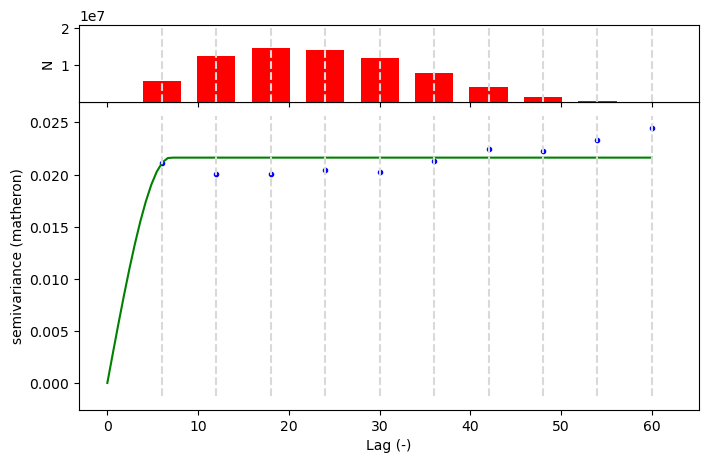

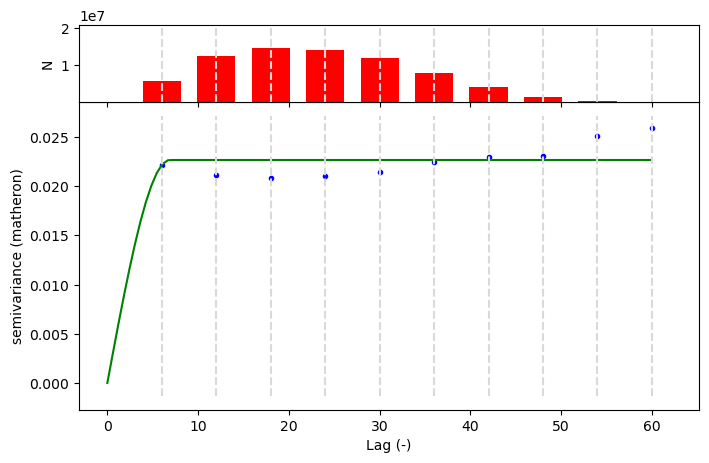

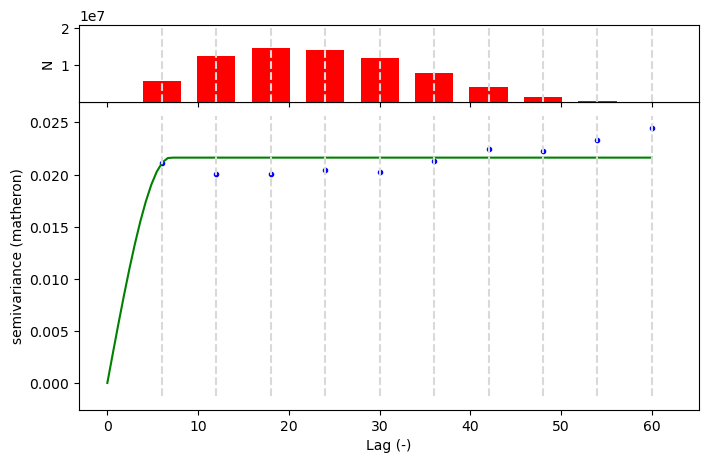

In [29]:
V_1.plot()
V_2.plot()

# Feature Importance

In [ ]:
def generate_gini_latex_table(df,param_names, table_label, table_caption, explanatory_var_labels):
    explanatory_var_map = {'u_av':'$u_{geo}$','v_av':'$v_{geo}$','lat':'lat','lon':'lon','day_of_year':'$t$',
    'Wx':'$w_x$','Wy':'$w_y$','Tx':'$\\tau_x$','Ty':'$\\tau_y$','sst_x_derivative':'$\\nabla_x SST$','sst_y_derivative':'$\\nabla_y SST$'}
    param_map = {'mu_x':'$\\mu_1$', 'mu_y':'$\\mu_2$', 'a_11':'$a_{11}$', 'a_12':'$a_{12}$','a_22':'$a_{22}$'}
    table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{l" + "c" * len(param_names) + "}\n\\hline\n"
    table += "\\textbf{Variable} & " + " & ".join([f"\\textbf{{{param_map[var_label]}}}" for var_label in param_names]) + " \\\\\n\\hline\n"
    for _, row in df[df["variable"].isin(explanatory_var_labels)].iterrows():
        explanatory_var_label = f"{explanatory_var_map[row['variable']]}"
        
        # # Main row with mean ± std
        # table += f"{explanatory_var_label} & " + " & ".join(
        #     [f"${100*row[f'{var_label} mean']:.2f} \\pm {100*row[f'{var_label} std']:.2f}$" for var_label in param_names]
        # ) + " \\\\\n"

        # # Confidence interval row
        # table += "& " + " & ".join(
        #     [f"\\footnotesize ({100*row[f'{var_label} ci'][0]:.2f}, {100*row[f'{var_label} ci'][1]:.2f})" for var_label in param_names]
        # ) + " \\\\\n\\hline\n"

        table += f"{explanatory_var_label} & " + " & ".join(
             [f"${100*row[f'{var_label} mean']:.2f}$" for var_label in param_names]
         ) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += f"\\caption{{{table_caption}}}\n"
    table += f"\\label{{{table_label}}}\n"
    table += "\\end{table}\n"

    return table


In [ ]:
# load models
# for non-polar
explanatory_var_labels = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative']
#df = pd.dataframe(columns=['replication_id','variable','u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative'])

def get_gini_importances(root_dir,file_name_prefix,file_name_suffix,config_id,replication_ids,explanatory_var_labels):
    # initialise
    row_count = 0
    params = ['mu_x', 'mu_y', 'a_11', 'a_12','a_22']
    df_dict = {}
    # loop over models
    for kk,rep_id in enumerate(replication_ids[config_id]):
        with open(fr'{root_dir}/{file_name_prefix}{replication_ids[config_id][kk]}{file_name_suffix}.p', 'rb') as pickle_file:
            model = pickle.load(pickle_file)
        fi = model.feature_importances_
        for ii, var in enumerate(explanatory_var_labels):
            new_row = [rep_id,var]
            for jj,param in enumerate(params):
                new_row.append(fi[jj][ii])
            row_count+=1
            df_dict[row_count] = new_row
    return df_dict

In [ ]:
my_dict = get_gini_importances(root_dir,file_name_prefix,file_name_suffix,38,replication_ids,explanatory_var_labels)

In [ ]:
gini_by_replication = pd.DataFrame(my_dict.values(),columns=['replication_id','variable','mu_x', 'mu_y', 'a_11', 'a_12','a_22'])

In [ ]:
gini_by_replication_data = gini_by_replication.groupby('variable')[['replication_id','mu_x', 'mu_y', 'a_11', 'a_12','a_22']]

In [ ]:
gini_by_replication_summaries =pd.DataFrame({})

In [ ]:
import scipy.stats as stats
param_names = ['mu_x', 'mu_y', 'a_11', 'a_12','a_22']
for name in param_names:
    mean = gini_by_replication_data.apply(lambda g: np.mean(g[name]))
    std = gini_by_replication_data.apply(lambda g: np.std(g[name],ddof=1))
    gini_by_replication_summaries[f'{name} mean']=mean
    gini_by_replication_summaries[f'{name} std']=std
    ci = gini_by_replication_data.apply(lambda g: stats.t.interval(confidence=0.95, df=g.size-1, 
              loc=np.mean(g[name]), 
              scale=np.std(g[name],ddof=1)))
    gini_by_replication_summaries[f'{name} ci']=ci

In [ ]:
(gini_by_replication_summaries).reset_index()

,variable,mu_x mean,mu_x std,mu_x ci,mu_y mean,mu_y std,mu_y ci,a_11 mean,a_11 std,a_11 ci,a_12 mean,a_12 std,a_12 ci,a_22 mean,a_22 std,a_22 ci
0,Tx,0.030321,0.002183,"(0.026032427637081513, 0.034608575349756476)",0.037825,0.002389,"(0.03313413880411428, 0.04251619992730739)",0.048569,0.002652,"(0.04336036928983017, 0.05377719639762267)",0.061980,0.003383,"(0.055336449183365374, 0.06862287924542988)",0.048359,0.002843,"(0.04277623009236388, 0.05394139013165908)"
1,Ty,0.034505,0.002039,"(0.030500700901019334, 0.038509533148565686)",0.032252,0.002450,"(0.02744016707044343, 0.03706359801307149)",0.051629,0.002616,"(0.04649214095200011, 0.0567657146927421)",0.052975,0.003140,"(0.04680870082629581, 0.05914224687117974)",0.046298,0.002643,"(0.041107087110991904, 0.0514889861017729)"
2,Wx,0.030018,0.002250,"(0.02559971975777421, 0.03443710502951716)",0.036005,0.002147,"(0.03178884635848567, 0.04022093391076885)",0.049075,0.002604,"(0.0439603079850832, 0.05419029039581501)",0.065739,0.003287,"(0.05928444842181313, 0.07219392294356983)",0.048459,0.002693,"(0.043170773382757974, 0.05374662959635962)"
3,Wy,0.032317,0.002101,"(0.028189867985525568, 0.03644351708999731)",0.030323,0.002441,"(0.025528156906766086, 0.03511776493245449)",0.047648,0.002690,"(0.0423647808235093, 0.05293051384535897)",0.055032,0.003464,"(0.04822934647124831, 0.061834813220488075)",0.049344,0.003110,"(0.04323742812939357, 0.0554511250508705)"
4,day_of_year,0.063115,0.002910,"(0.05739898905250647, 0.06883038947531876)",0.073025,0.002973,"(0.06718496070564736, 0.07886420812895151)",0.101854,0.003226,"(0.09551938012160748, 0.10818904460893285)",0.086501,0.003766,"(0.07910515154902312, 0.09389626949965696)",0.103285,0.003275,"(0.09685451872658216, 0.10971636416597003)"
5,lat,0.263110,0.006389,"(0.25056298745634925, 0.2756579467370944)",0.226785,0.006037,"(0.2149273059779128, 0.23864178287902996)",0.203492,0.005799,"(0.19210338548857267, 0.21488085111233793)",0.178628,0.006671,"(0.16552737772364914, 0.19172948616152377)",0.195922,0.005401,"(0.18531449263816574, 0.2065287183992902)"
6,lon,0.237810,0.006263,"(0.22550985550674385, 0.2501091595253428)",0.206839,0.005391,"(0.19625049881289675, 0.21742696868341632)",0.169003,0.004991,"(0.15920140548787146, 0.17880480517838962)",0.150229,0.005172,"(0.14007201644373735, 0.16038660987361042)",0.175321,0.004676,"(0.16613744718764467, 0.1845041714310413)"
7,sst_x_derivative,0.056539,0.002318,"(0.0519865408097276, 0.061091893431510016)",0.082345,0.002986,"(0.07648049071658977, 0.08821034180565282)",0.067095,0.002934,"(0.061333658019963114, 0.07285613205371368)",0.076058,0.003391,"(0.06939759289074071, 0.08271795044215155)",0.078670,0.002833,"(0.0731058346894755, 0.08423329054488267)"
8,sst_y_derivative,0.075761,0.003143,"(0.06958886251561774, 0.08193346502587467)",0.065779,0.002639,"(0.06059563684167761, 0.0709620714318709)",0.076009,0.003241,"(0.06964340950440812, 0.08237426658560532)",0.089540,0.003786,"(0.08210421258741403, 0.09697595830739576)",0.065799,0.002994,"(0.05991882956721937, 0.07167960451120352)"
9,u_av,0.111914,0.003116,"(0.10579434355476945, 0.11803365744023174)",0.074920,0.004037,"(0.06699263346964338, 0.08284805172159027)",0.102335,0.003116,"(0.09621638218071321, 0.10845453136411415)",0.086829,0.003675,"(0.0796117550428335, 0.09404701364929462)",0.088733,0.002909,"(0.08301911334362043, 0.09444642403855703)"


In [ ]:
param_names = ['mu_x', 'mu_y', 'a_11', 'a_12','a_22']
table_label = 'tab:gini-importances'
table_caption = 'Gini Importances'
print(generate_gini_latex_table(gini_by_replication_summaries.reset_index(),param_names, table_label, table_caption, explanatory_var_labels))

\begin{table}[h]
\centering
\begin{tabular}{lccccc}
\hline
\textbf{Variable} & \textbf{$\mu_1$} & \textbf{$\mu_2$} & \textbf{$a_{11}$} & \textbf{$a_{12}$} & \textbf{$a_{22}$} \\
\hline
$\tau_x$ & $3.03$ & $3.78$ & $4.86$ & $6.20$ & $4.84$ \\
\hline
$\tau_y$ & $3.45$ & $3.23$ & $5.16$ & $5.30$ & $4.63$ \\
\hline
$w_x$ & $3.00$ & $3.60$ & $4.91$ & $6.57$ & $4.85$ \\
\hline
$w_y$ & $3.23$ & $3.03$ & $4.76$ & $5.50$ & $4.93$ \\
\hline
$t$ & $6.31$ & $7.30$ & $10.19$ & $8.65$ & $10.33$ \\
\hline
lat & $26.31$ & $22.68$ & $20.35$ & $17.86$ & $19.59$ \\
\hline
lon & $23.78$ & $20.68$ & $16.90$ & $15.02$ & $17.53$ \\
\hline
$\nabla_x SST$ & $5.65$ & $8.23$ & $6.71$ & $7.61$ & $7.87$ \\
\hline
$\nabla_y SST$ & $7.58$ & $6.58$ & $7.60$ & $8.95$ & $6.58$ \\
\hline
$u_{geo}$ & $11.19$ & $7.49$ & $10.23$ & $8.68$ & $8.87$ \\
\hline
$v_{geo}$ & $6.46$ & $13.39$ & $8.33$ & $9.65$ & $9.98$ \\
\hline
\end{tabular}
\caption{Gini Importances}
\label{tab:gini-importances}
\end{table}

